# Time series outlier detection with Spectral Residuals on synthetic data

## Method

The Spectral Residual outlier detector is based on the paper [Time-Series Anomaly Detection Service at Microsoft](https://arxiv.org/abs/1906.03821) and is suitable for unsupervised online anomaly detection in univariate time series data. The algorithm first computes the [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) of the original data. Then it computes the *spectral residual* of the log amplitude of the transformed signal before applying the Inverse Fourier Transform to map the sequence back from the frequency to the time domain. This sequence is called the *saliency map*. The anomaly score is then computed as the relative difference between the saliency map values and their moving averages. If this score is above a threshold, the value at a specific timestep is flagged as an outlier. For more details, please check out the [paper](https://arxiv.org/abs/1906.03821).

## Dataset

We test the outlier detector on a synthetic dataset generated with the [TimeSynth](https://github.com/TimeSynth/TimeSynth) package. It allows you to generate a wide range of time series (e.g. pseudo-periodic, autoregressive or Gaussian Process generated signals) and noise types (white or red noise). It can be installed as follows:

```bash
!pip install git+https://github.com/TimeSynth/TimeSynth.git
```

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
import timesynth as ts

from alibi_detect.od import SpectralResidual
from alibi_detect.utils.perturbation import inject_outlier_ts
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_ts

## Create univariate time series

Define number of sampled points and the type of simulated time series. We use [TimeSynth](https://github.com/TimeSynth/TimeSynth) to generate a sinusoidal signal with Gaussian noise.

In [2]:
n_points = 100000

In [3]:
# timestamps
time_sampler = ts.TimeSampler(stop_time=n_points // 4)
time_samples = time_sampler.sample_regular_time(num_points=n_points)

# harmonic time series with Gaussian noise
sinusoid = ts.signals.Sinusoidal(frequency=0.25)
white_noise = ts.noise.GaussianNoise(std=0.1)
ts_harm = ts.TimeSeries(signal_generator=sinusoid, noise_generator=white_noise)
samples, signals, errors = ts_harm.sample(time_samples)
X = samples.reshape(-1, 1).astype(np.float32)
print(X.shape)

(100000, 1)


We can inject noise in the time series via `inject_outlier_ts`. The noise can be regulated via the percentage of outliers (`perc_outlier`), the strength of the perturbation (`n_std`) and the minimum size of the noise perturbation (`min_std`):

In [4]:
data = inject_outlier_ts(X, perc_outlier=10, perc_window=10, n_std=2., min_std=1.)
X_outlier, y_outlier, labels = data.data, data.target.astype(int), data.target_names
print(X_outlier.shape, y_outlier.shape)

(100000, 1) (100000,)


Visualize part of the original and perturbed time series:

In [5]:
n_plot = 200

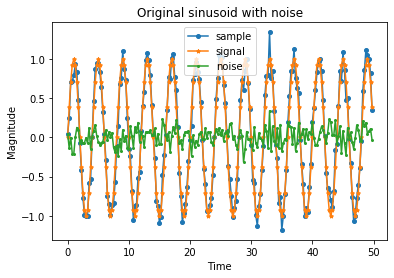

In [6]:
plt.plot(time_samples[:n_plot], X[:n_plot], marker='o', markersize=4, label='sample')
plt.plot(time_samples[:n_plot], signals[:n_plot], marker='*', markersize=4, label='signal')
plt.plot(time_samples[:n_plot], errors[:n_plot], marker='.', markersize=4, label='noise')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Original sinusoid with noise')
plt.legend()
plt.show();

Perturbed data:

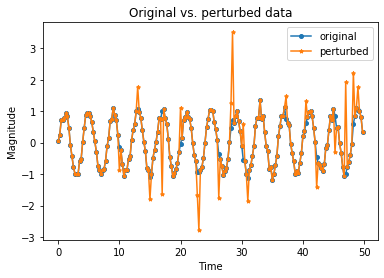

In [7]:
plt.plot(time_samples[:n_plot], X[:n_plot], marker='o', markersize=4, label='original')
plt.plot(time_samples[:n_plot], X_outlier[:n_plot], marker='*', markersize=4, label='perturbed')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Original vs. perturbed data')
plt.legend()
plt.show();

## Define Spectral Residual outlier detector

In [8]:
od = SpectralResidual(
    threshold=None,  # threshold for outlier score
    window_amp=20,   # window for the average log amplitude
    window_local=20, # window for the average saliency map
    n_est_points=20  # nb of estimated points padded to the end of the sequence
)

The warning tells us that we need to set the outlier threshold. This can be done with the `infer_threshold` method. We need to pass a batch of instances and specify what percentage of those we consider to be normal via `threshold_perc`. Let's assume we have some data which we know contains around 10% outliers:

In [9]:
X_threshold = X_outlier[:10000, :]

Let's infer the threshold:

In [10]:
od.infer_threshold(X_threshold, time_samples[:10000], threshold_perc=90)
print('New threshold: {:.4f}'.format(od.threshold))

New threshold: 1.1818


Let's save the outlier detector with the updated threshold:

In [11]:
filepath = 'my_path'
save_detector(od, filepath)

We can load the same detector via `load_detector`:

In [12]:
od = load_detector(filepath)

## Detect outliers

Predict outliers:

In [13]:
od_preds = od.predict(X_outlier, time_samples, return_instance_score=True)

## Display results

F1 score, accuracy, recall and confusion matrix:

F1 score: 0.8922542204568024 -- Accuracy: 0.9783 -- Recall: 0.8985


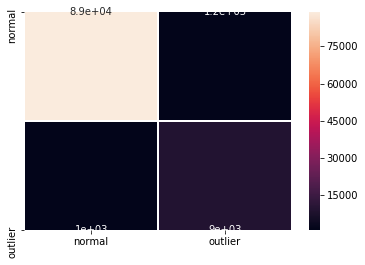

In [14]:
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
acc = accuracy_score(y_outlier, y_pred)
rec = recall_score(y_outlier, y_pred)
print('F1 score: {} -- Accuracy: {} -- Recall: {}'.format(f1, acc, rec))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot the outlier scores of the time series vs. the outlier threshold. :

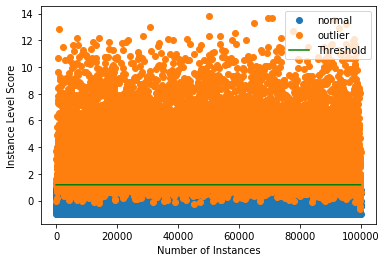

In [15]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)

Let's zoom in on a smaller time scale to have a clear picture:

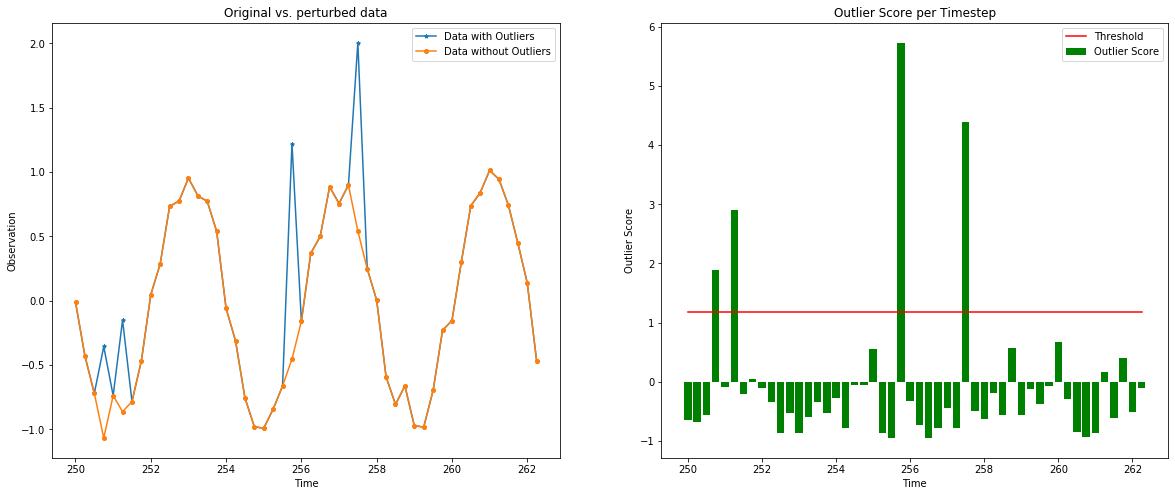

In [17]:
plot_feature_outlier_ts(od_preds, 
                        X_outlier, 
                        od.threshold,
                        window=(1000, 1050),
                        t=time_samples,
                        X_orig=X)